<a href="https://colab.research.google.com/github/DarekGit/FACES_DNN/blob/master/notebooks/WIDERFACE_Detectron2_from_scratch_DD_mobilenet_v2_BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detectron2 z backbone na Mibilenet_v2

dolozony BN do wersji MN2

LR=1-3 

Gamma=0.5

Scheduler 40/100/200/400k

Max 800k

# Install detectron2

Detectron2  https://github.com/facebookresearch/detectron2 <br>
Detectron2 Beginner's Tutorial https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5 <br>
Documentation https://detectron2.readthedocs.io <br>
Detectron2 Model Zoo and Baselines https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md <br>
Rethinking ImageNet Pre-training https://arxiv.org/pdf/1811.08883.pdf <br>

Wykorzystano kody z <br>
https://github.com/youngwanLEE/vovnet-detectron2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
#!pip install -U torch==1.5  -f https://download.pytorch.org/whl/cu101/torch_stable.html  #torchvision==0.5
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# install detectron2:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -q -e detectron2_repo

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=5a7e1f2058f22651edd149d6b60368820b1421d7898ae3bffd6d77f7b16f2b8a
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-1kq2fl55
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-1kq2fl55
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=267007 sha256=788060899015395fb30831906b25f38b0b00dc34ed0a43f5e269908374feda73
  Stored in directory: /tmp/pip-ephem-wheel-cache-mfqdttcm/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing install

In [ ]:

!gdown https://drive.google.com/uc?id=1U0SVkSaSio4TBiXvF1QfTZI65WYpXpZ9
!unzip -qo mobilenet.zip


Downloading...
From: https://drive.google.com/uc?id=1U0SVkSaSio4TBiXvF1QfTZI65WYpXpZ9
To: /content/mobilenet.zip
100% 7.22k/7.22k [00:00<00:00, 18.7MB/s]


In [ ]:
'''
!gdown https://drive.google.com/uc?id=10d2beeImU11qFdkttexoUNoaLkMszY2a
!unzip -q detectron2_repo.zip

!pip install -q -e detectron2_repo
'''

<font color=red> Restart runtime to continue... <b>Crtl+M.</b> </font>

In [ ]:
!nvidia-smi
from psutil import virtual_memory
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(virtual_memory().total / 1e9))

Thu May 28 06:46:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from google.colab import drive
import os
import cv2
import random
import itertools
import shutil
import glob
import json
import numpy as np
import pandas as pd
from PIL import ImageDraw, Image
from collections import defaultdict
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
import detectron2.utils.comm as comm
from detectron2.engine import DefaultPredictor, DefaultTrainer, HookBase
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.structures import BoxMode
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

In [ ]:
from mobilenet.utils import  add_mobilenet_config, build_mobilenetv2_fpn_backbone


# Prepare the dataset

## WIDER FACE: A Face Detection Benchmark
http://shuoyang1213.me/WIDERFACE/ <br>

https://arxiv.org/pdf/1511.06523.pdf <br>


In [ ]:
### WIDER Face Training Images
#!gdown https://drive.google.com/uc?id=0B6eKvaijfFUDQUUwd21EckhUbWs
!gdown https://drive.google.com/uc?id=1-1iJfmXKYvAx9uLdRDX5W6HHG_KZv1jH

### WIDER Face Validation Images
#!gdown https://drive.google.com/uc?id=0B6eKvaijfFUDd3dIRmpvSk8tLUk
!gdown https://drive.google.com/uc?id=1-5A_pa_jDS7gk8mHVCBB7ApV5KN8jWDr

### WIDER Face Testing Images
#!gdown https://drive.google.com/uc?id=0B6eKvaijfFUDbW4tdGpaYjgzZkU
#!gdown https://drive.google.com/uc?id=1tTpUJZEQMKDVxKT6100V5FwDuGX_8sDi

### Face annotations
!wget mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip

### Examples and formats of the submissions
#!wget mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/example/Submission_example.zip

!unzip -q WIDER_train.zip
!rm WIDER_train.zip
!unzip -q WIDER_val.zip
!rm WIDER_val.zip
#!unzip -q WIDER_test.zip
#!rm WIDER_test.zip
!unzip -q wider_face_split.zip
!rm wider_face_split.zip

Downloading...
From: https://drive.google.com/uc?id=1-1iJfmXKYvAx9uLdRDX5W6HHG_KZv1jH
To: /content/WIDER_train.zip
1.47GB [00:11, 132MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-5A_pa_jDS7gk8mHVCBB7ApV5KN8jWDr
To: /content/WIDER_val.zip
363MB [00:07, 51.2MB/s]
--2020-05-28 06:48:13--  http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip
Resolving mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)... 137.189.99.12
Connecting to mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)|137.189.99.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3591642 (3.4M) [application/zip]
Saving to: ‘wider_face_split.zip’

wider_face_split.zi 100%[===================>]   3.42M  2.41MB/s    in 1.4s    

2020-05-28 06:48:16 (2.41 MB/s) - ‘wider_face_split.zip’ saved [3591642/3591642]



In [ ]:
annotations = dict()
annotations["train"] = 'wider_face_split/wider_face_train_bbx_gt.txt' 
annotations["val"] = 'wider_face_split/wider_face_val_bbx_gt.txt'
annotations

{'train': 'wider_face_split/wider_face_train_bbx_gt.txt',
 'val': 'wider_face_split/wider_face_val_bbx_gt.txt'}

In [ ]:
def widerface_annotations(annotations):
  """Function for reading faces bounding box annotations for WIDER Face dataset
  
  Parameters:
  ----------
  :param dict annotations: dictionary with annotations files path 
                           { "train" : WIDER_train_annotations_path,
                             "val"   : WIDER_val_annotations_path }

  :return annotation_dict: annotation dictionary

  Face annotations:
  ----------------
  file_name
  number_of_bounding_box
  bbox [x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose]

  Mappings between attribute names and label values:
  -------------------------------------------------
  blur:
    clear->0
    normal blur->1
    heavy blur->2

  expression:
    typical expression->0
    exaggerate expression->1

  illumination:
    normal illumination->0
    extreme illumination->1

  occlusion:
    no occlusion->0
    partial occlusion->1
    heavy occlusion->2

  pose:
    typical pose->0
    atypical pose->1

  invalid:
    false->0 (valid image)
    true->1 (invalid image)
  """

  annotation_dict = defaultdict(list)
  for key, value in annotations.items():
    with open(value, "r") as file_:
      rows = file_.readlines()

    idx = 0
    while (idx < len(rows)):
      file_name = rows[idx].replace("\n", "")
      number_of_bounding_box = int(rows[idx+1])
      bbox = []
      '''
      Attention! there are photos without annotations..
      0--Parade/0_Parade_Parade_0_452.jpg
      0
      0 0 0 0 0 0 0 0 0 0 
      '''
      jump = number_of_bounding_box if number_of_bounding_box != 0 else 1

      for i in range(1, jump+1):
        box = rows[idx+1+i]
        box = [int(item) for item in box.split(' ')[:10]]
        bbox.append(box)

      annotation_dict[key].append({
          'file_name'             : file_name,
          'number_of_bounding_box': number_of_bounding_box, 
          'bbox'                  : bbox
      })
      idx += (jump+2)

  return annotation_dict

In [ ]:
annotation_dict = widerface_annotations(annotations)

In [ ]:
PATH_dict = { 
    'train'           : 'WIDER_train',      # path to the train directory
    'val'             : 'WIDER_val',        # path to the validation directory 
    'annotation_dir'  : 'wider_face_split'  # path to annotation directory 
}

output_files = {
    'train' : 'wider_face_train_coco.json',
    'val'   : 'wider_face_val_coco.json'
}

In [ ]:
def Convert_annotation(annotation_dict, IMAGES_PATH):
  """Function 
  """
  dataset_dicts = []
  for idx, item in enumerate(annotation_dict):
    record = {}
    record["image_id"] = idx
    record['file_name'] = os.path.join(os.path.join(IMAGES_PATH,"images"), item["file_name"])
    img_ = Image.open(os.path.join(os.path.join(IMAGES_PATH,"images"), item["file_name"]))
    record['width'] = img_.width
    record['height'] = img_.height
    bbox = [i[:4] for i in item['bbox']]
    annotation = []
    for box in bbox:
        anno = {}
        xmin, ymin, xmax, ymax = int(box[0]), int(box[1]), int(box[0])+int(box[2]), int(box[1])+int(box[3])
        polygon = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
        polygon = list(itertools.chain.from_iterable(polygon))
        anno['category_id'] = 0 
        anno['iscrowd'] = 0
        anno['bbox'] = [xmin, ymin, xmax, ymax]
        anno['bbox_mode'] = BoxMode.XYXY_ABS
        anno['segmentation'] = [polygon]
        annotation.append(anno)
    record["annotations"] = annotation    
    dataset_dicts.append(record)
  return dataset_dicts

In [ ]:
train = Convert_annotation(annotation_dict["train"], PATH_dict['train'])
val = Convert_annotation(annotation_dict["val"], PATH_dict['val'])

In [ ]:
for d in ["train", "val"]:
  DatasetCatalog.register("face_" + d, lambda d=d: train if d == "train" else val)
  MetadataCatalog.get("face_" + d).set(thing_classes = ['face'])

faces_metadata = MetadataCatalog.get("face_train")

# "Base-RCNN-MobileNet-FPN_v1.yaml"
mobilenet/configs


In [ ]:
cfg = get_cfg()

cfg_file='Base-RCNN-MobileNet-FPN_V1.yaml'
cfg.merge_from_file('mobilenet/configs/'+cfg_file)
add_mobilenet_config(cfg)
cfg.MODEL.MOBILENET.NORM='BN'


Loading config mobilenet/configs/Base-RCNN-MobileNet-FPN_V1.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [ ]:
print(cfg.dump())


In [ ]:

cfg.DATASETS.TRAIN = ("face_train",)
cfg.DATASETS.TEST = ("face_val",)
cfg.DATALOADER.NUM_WORKERS = 4

#cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detectron2/Misc/scratch_mask_rcnn_R_50_FPN_9x_gn/183808979/model_final_da7b4c.pkl'

'''
from torch.utils.model_zoo import load_url as load_state_dict_from_url
state_dict = load_state_dict_from_url(
'https://www.dropbox.com/s/47tyzpofuuyyv1b/mobilenetv2_1.0-f2a8633.pth.tar?dl=1', progress=True)
torch.save(state_dict,'MN2.pth')
'''

cfg.MODEL.WEIGHTS = "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" # 'MN2.pth'

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  #  LR
cfg.SOLVER.MAX_ITER = 800000    

cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.STEPS =[40000,100000,200000,400000]
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.CHECKPOINT_PERIOD = 10000

#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 1024   # (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class 


In [ ]:

# OUTPUT_DIR on Google Drive
drive.mount('/content/drive')

cfg.OUTPUT_DIR = os.path.join("./drive/My Drive/Face detection", "output_MN2_BN")
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# validation loss during training
# https://github.com/facebookresearch/detectron2/issues/810
# https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e


cfg.DATASETS.VAL = ("face_val",)

class Validation_Loss(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.VAL
        self._loader = iter(build_detection_train_loader(self.cfg))
        
    def after_step(self):
        data = next(self._loader)
        with torch.no_grad():
            loss_dict = self.trainer.model(data)
            
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = { k+"/val": v.item() for k, v in comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            loss_dict_reduced['total_loss/val']=losses_reduced
            if comm.is_main_process():
                self.trainer.storage.put_scalars(**loss_dict_reduced) #total_val_loss

In [ ]:
import json
cfg_all=cfg_file.split('.')[-2]+'_ALL.json'
cfg_all = os.path.join(cfg.OUTPUT_DIR, cfg_all)
with open(cfg_all,'w') as f:
  json.dump(cfg,f)


In [ ]:

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 

val_loss = Validation_Loss(cfg)  
trainer.register_hooks([val_loss])
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]

trainer.resume_or_load(resume=True)
trainer.train()

Streaming output truncated to the last 5000 lines.
[05/28 10:10:46 d2.utils.events]:  eta: 5:53:24  iter: 700699  total_loss: 0.273  loss_cls: 0.071  loss_box_reg: 0.156  loss_rpn_cls: 0.024  loss_rpn_loc: 0.018  loss_cls/val: 0.069  loss_box_reg/val: 0.135  loss_rpn_cls/val: 0.016  loss_rpn_loc/val: 0.014  total_loss/val: 0.283  time: 0.2149  data_time: 0.0054  lr: 0.000063  max_mem: 12687M
[05/28 10:10:54 d2.utils.events]:  eta: 5:53:46  iter: 700719  total_loss: 0.249  loss_cls: 0.075  loss_box_reg: 0.118  loss_rpn_cls: 0.010  loss_rpn_loc: 0.017  loss_cls/val: 0.095  loss_box_reg/val: 0.194  loss_rpn_cls/val: 0.045  loss_rpn_loc/val: 0.033  total_loss/val: 0.398  time: 0.2149  data_time: 0.0053  lr: 0.000063  max_mem: 12687M
[05/28 10:11:02 d2.utils.events]:  eta: 5:53:39  iter: 700739  total_loss: 0.164  loss_cls: 0.049  loss_box_reg: 0.110  loss_rpn_cls: 0.007  loss_rpn_loc: 0.008  loss_cls/val: 0.118  loss_box_reg/val: 0.205  loss_rpn_cls/val: 0.020  loss_rpn_loc/val: 0.024  tot

In [ ]:
#cfg.freeze()
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 

val_loss = Validation_Loss(cfg)  
trainer.register_hooks([val_loss])
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]

trainer.resume_or_load(resume=True)
trainer.train()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir 'drive/My Drive/Face detection/output_MN2'

In [ ]:
def load_json(json_path):
  data = []
  with open(json_path, 'r') as f:
    for line in f:
      data.append(json.loads(line))
  return data

results = load_json(cfg.OUTPUT_DIR + '/metrics.json')
x = [i["iteration"] for i in results]
y_total_loss = [i["total_loss"] for i in results]
x_val_loss = [i["iteration"] for i in results if "total_loss/val" in i]
y_total_val_loss = [i["total_loss/val"] for i in results ]#if "total_loss/val" in i]

plt.figure(figsize=(15,5))
plt.plot(x, y_total_loss)
plt.plot(x_val_loss, y_total_val_loss )
plt.legend(['total_loss', 'VAL/total_loss'])
plt.savefig('Loss_train_val.jpg')
plt.show()


Użycie modelu

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("face_val", )
predictor = DefaultPredictor(cfg)

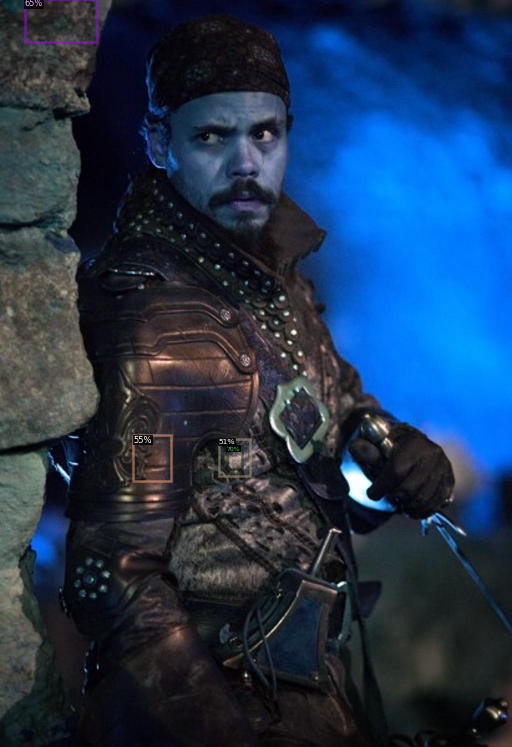

In [ ]:
dataset_dicts = val
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im[:, :, ::-1])
    v = Visualizer(im,metadata=faces_metadata, scale=0.5)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

AP metric on val

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("face_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "face_val")
inference_on_dataset(trainer.model, val_loader, evaluator)